# Introduction


### Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV) 
* https://arxiv.org/pdf/1711.11279.pdf
* Interpretability method made by Google AI researchers, main author is Been Kim
* Introduced late 2017

### Why have I used this?


### Interpretability / Explainability

* Neural networks are "black boxes".
* Want to explain why a particular classification was made by a neural network
* Some ideal goals an interpretability method: Accessibility, Customization, Plug-in readiness, Global quantification
    * TCAV aims to achieve all of these!



### Saliency Maps
* Give importance weights to indivudual pixels for a classification based on first order derivatives. Essentially - gauges the sensitivity of the output classk to changes in the magnitude of single pixel
* Local method - provides information about a single classification rather than about the entire model.
* Qualitative method - inspect results manually to determine important concepts
* Output from the method is essentially a heat map, brightness of pixel represents importance

![alt text](Saliencymap.png "Example saliency map")

* Model is looking where we want it to but this explanation leaves a lot to be desired
    * Does the presence of a human effect the prediction? Is the presence of paper important?
    * How important is one concept relative to another?
    * Can we quantify the brightness?
    

### TCAV

Motivation:
Something higher level than individual pixels, such as concepts would be nice. This could be used to see when our model has learned something that is in contradiction with our knowledge. Can check if our model has picked up on any unexpected biases. Is one concept more important than another?

Concepts? High level ideas.
* Human (e.g. for cash machine class) 
* Arms (e.g. for dumbbells class)
* Stripes (e.g. for zebra class)
* Plenty of medical examples, such as diabetic retinopathy

Q: how do you represent concepts?


####  Concept Activation Vectors (CAVs)

To make a CAV for a concept, we need
* Images that represent a concept (positive images)
* Images that do not (negative images, also called random images)
* Images of the class in question

CAVs are a vector from negative to positive examples of a concept, i.e. one from low activations to high activations. CAVs capture the concept in question. Will get different CAVs for each different layer in the model, for each concept and for each target class.

![alt text](cav.png "CAVs")

CAV created from training a binary linear classifier from high activations in our model to low activations.

TODO (how does it work)?

#### Using the CAVs

How does this help?

Remember, we add a CAV to the activations in a layer in our model of the prediction, not to an image. Adding a CAV can have some effect on the prediction, we want to quantify this

Given an image of our target class, approximate the directional derivative of the output prediction with repsect to the CAV for that layer.

Essentially a local method at this point, output is a number representing "the sensitivity of predictions to changes in inputs towards the direction of a concepts at a layer".
* Positive -> CAV made a change in the prediction that made this class more likely 
* Zero -> CAV made no change to prediction
* Negative -> CAV made a change in the prediction that made this class less likely 

#### Calculating TCAV score

Find fraction of images in the class which have a positive "conceptual sensitivity". This is the TCAV score, between 0 and 1.
* 1 -> concept is important for this class
* 0.5 -> concept is not important for this class (close to zero sensitivity) 
* 0 -> concept is important for this class, but has a "negative effect" on the prediction

Now a global method!

Logical extension: incorporate magnitude into final score. Can use this to differentiate between two concepts with the same score


#### Random concept

Want to ensure CAV isn't causing a high sensitivity by change e.g. due to choice of negative images. 

So, use the same positive image set, but many different negative image sets. Should be a normal distribution of TCAV scores. Compare this to a distribution from a random concept - both positive and negative sets are negative images (i.e. with two sided t-test). Random concept should ideally have a TCAV score of 0.5 - sanity check.


![alt text](randomtests.png "Statistical testing")

Instead... could use relative TCAV to compare many positive image sets.

### Which layers should I look at?

Bottleneck layers - the layers that the output entirely depends on.

Example - Inception v3 architecture. Bottleneck layers are mixed1, mixed2, ..., mixed10

Deeper layers should be dealing with higher level features
![alt text](inceptionv3architecture.png "Inceptionv3")

# The code

* Open source, Apache-2.0 licensed https://github.com/tensorflow/tcav
* `pip install tcav`
* requires tensorflow=1.13

Changes that are not present in the repo
* Sorting by activation

Things to note
* I am using keras
* Ignore the warnings


### Imports

In [1]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
import os

from tcav import model as tcav_model
from tcav import tcav as tcav
from tcav import utils as utils
from tcav import activation_generator as act_gen
from tcav import utils_plot as utils_plot

Using TensorFlow backend.


In [2]:
tf.logging.set_verbosity(tf.logging.INFO)

### Load model

In [3]:
sess = K.get_session()

W0825 10:16:16.270653  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0825 10:16:16.272652  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0825 10:16:16.272652  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0825 10:16:16.291640  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [4]:
model = load_model('inceptionv3.h5')

W0825 10:16:16.301635  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 10:16:16.360602  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0825 10:16:16.577478  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0825 10:16:16.856318  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0825 10:16:26.47

### Parameters

*Show folder structure now*

Create a directory for all source images. Now, within this directory, create a folder for each concept. The folder name should be the name of the concept in the above list. Same for the target classes. It is recommended to have 50 to 200 images of each. The images can be of any size.

You should also have a folder of images of your target class.

For the negative examples, you will have to create a new folder for the number of random experiments you want to run. These folders are called random500_0, random500_1, etc. The number of random trials are specified later.

In [19]:
# Create list names of target concepts
concepts = [
    "dark_brown",
    "sand_texture",
    "green",
    "dark_blue_colour",
    "mel_with_blue_white_veil",
]

# Name of target class
# can only run once at a time
target = "mel"

# Create a list of target layers in the model
# Some InceptionV3 bottlenecks
bottlenecks = [
    "mixed9",
    "mixed10"
]

In [6]:
# The path for a folder to store all the images required for TCAV
source_dir = 'img'

In [7]:
# random folders are named random500_0, random500_1, ... , random500_10
random_concepts = [f'random500_{i}' for i in range(0, 11)]

Ensure the following assertions succeed

In [8]:
assert os.path.isdir(source_dir)

for x in concepts:
    assert os.path.isdir(os.path.join(source_dir, x))

assert os.path.isdir(os.path.join(source_dir, target))

Other parameters

In [9]:
# Where activations are stored
activation_dir = 'activations'

# Where CAVs are stored
cav_dir = 'cavs'

# Create directories
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(cav_dir)

# "this is a regularizer penalty parameter for linear classifier to get CAVs"
alphas = [0.1]

W0825 10:16:39.441917  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\tcav\utils.py:222: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0825 10:16:39.442916  8980 deprecation_wrapper.py:119] From C:\Users\2gare\Anaconda3\envs\tcav_demo\lib\site-packages\tcav\utils.py:223: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.



### Using our keras model with tensorflow

In [10]:
# Modified version of PublicImageModelWrapper in TCAV's models.py
# This class takes a session which contains the already loaded graph.
# Also accesses the keras model to get info from
# This model also assumes softmax is used with categorical crossentropy.
class CustomPublicImageModelWrapper(tcav_model.ImageModelWrapper):
    def __init__(self, sess, labels, image_shape,
                endpoints_dict, name, image_value_range):
        super(self.__class__, self).__init__(image_shape)
        
        self.sess = sess
        self.labels = labels
        self.model_name = name
        self.image_value_range = image_value_range

        # get endpoint tensors
        self.ends = {'input': endpoints_dict['input_tensor'],
                     'prediction': endpoints_dict['prediction_tensor']}
        
        self.bottlenecks_tensors = self.get_bottleneck_tensors()
        # load current graph
        graph = tf.get_default_graph()

        # Construct gradient ops.
        with graph.as_default():
            self.y_input = tf.placeholder(tf.int64, shape=[None])

            self.pred = tf.expand_dims(self.ends['prediction'][0], 0)
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits_v2(
                    labels=tf.one_hot(
                        self.y_input,
                        self.ends['prediction'].get_shape().as_list()[1]),
                    logits=self.pred))
        self._make_gradient_tensors()

    def id_to_label(self, idx):
        return self.labels[idx]

    def label_to_id(self, label):
        return self.labels.index(label)

    @staticmethod
    def create_input(t_input, image_value_range):
        """Create input tensor."""
        def forget_xy(t):
            """Forget sizes of dimensions [1, 2] of a 4d tensor."""
            zero = tf.identity(0)
            return t[:, zero:, zero:, :]

        t_prep_input = t_input
        if len(t_prep_input.shape) == 3:
            t_prep_input = tf.expand_dims(t_prep_input, 0)
        t_prep_input = forget_xy(t_prep_input)
        lo, hi = image_value_range
        t_prep_input = lo + t_prep_input * (hi-lo)
        return t_input, t_prep_input

    @staticmethod
    def get_bottleneck_tensors():
        """Add Inception bottlenecks and their pre-Relu versions to endpoints dict."""
        graph = tf.get_default_graph()
        bn_endpoints = {}
        for op in graph.get_operations():
            # change this below string to change which layers are considered bottlenecks
            # use 'ConcatV2' for InceptionV3
            # use 'MaxPool' for VGG16 (for example)
            if 'ConcatV2' in op.type:
                name = op.name.split('/')[0]
                bn_endpoints[name] = op.outputs[0]
            
        return bn_endpoints

In [11]:
# input is the first tensor, logit and prediction is the final tensor.
# we can get these endpoints directly from keras
endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

In [12]:
endpoints_v3

{'input': 'input_1:0',
 'input_tensor': <tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>,
 'logit': 'dense_2/Softmax:0',
 'prediction': 'dense_2/Softmax:0',
 'prediction_tensor': <tf.Tensor 'dense_2/Softmax:0' shape=(?, 2) dtype=float32>}

In [13]:
mymodel = CustomPublicImageModelWrapper(sess, 
        ['nv', 'mel'], [224, 224, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

In [14]:
mymodel.get_bottleneck_tensors()

{'mixed0': <tf.Tensor 'mixed0/concat:0' shape=(?, 25, 25, 256) dtype=float32>,
 'mixed1': <tf.Tensor 'mixed1/concat:0' shape=(?, 25, 25, 288) dtype=float32>,
 'mixed2': <tf.Tensor 'mixed2/concat:0' shape=(?, 25, 25, 288) dtype=float32>,
 'mixed3': <tf.Tensor 'mixed3/concat:0' shape=(?, 12, 12, 768) dtype=float32>,
 'mixed4': <tf.Tensor 'mixed4/concat:0' shape=(?, 12, 12, 768) dtype=float32>,
 'mixed5': <tf.Tensor 'mixed5/concat:0' shape=(?, 12, 12, 768) dtype=float32>,
 'mixed6': <tf.Tensor 'mixed6/concat:0' shape=(?, 12, 12, 768) dtype=float32>,
 'mixed7': <tf.Tensor 'mixed7/concat:0' shape=(?, 12, 12, 768) dtype=float32>,
 'mixed8': <tf.Tensor 'mixed8/concat:0' shape=(?, 5, 5, 1280) dtype=float32>,
 'mixed9_0': <tf.Tensor 'mixed9_0/concat:0' shape=(?, 5, 5, 768) dtype=float32>,
 'concatenate_1': <tf.Tensor 'concatenate_1/concat:0' shape=(?, 5, 5, 768) dtype=float32>,
 'mixed9': <tf.Tensor 'mixed9/concat:0' shape=(?, 5, 5, 2048) dtype=float32>,
 'mixed9_1': <tf.Tensor 'mixed9_1/concat

### Run TCAV

Loads images, used to get example images for a concept

In [15]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=200)

In [20]:
# can either specify a single negative concept or a list
mytcav = tcav.TCAV(sess,
        target, concepts, bottlenecks,
        act_generator, alphas,
        cav_dir=cav_dir,
        random_concepts=random_concepts)

results = mytcav.run(run_parallel=False)

I0825 11:08:30.544567  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_0'] mel 0.1
I0825 11:08:30.545566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_1'] mel 0.1
I0825 11:08:30.545566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_2'] mel 0.1
I0825 11:08:30.545566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_3'] mel 0.1
I0825 11:08:30.546566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_4'] mel 0.1
I0825 11:08:30.547566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_5'] mel 0.1
I0825 11:08:30.547566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_6'] mel 0.1
I0825 11:08:30.548566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_7'] mel 0.1
I0825 11:08:30.548566  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_8'] mel 0.1
I0825 11:08:30.549565  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_9'] mel 0.1
I0825 11:08:30.549565  8980 tcav.py:384] mixed9 ['dark_brown', 'random500_10'] mel 0.1
I0825 11:08:30.550565  8980 tcav.py:384] mixed9 ['san

I0825 11:08:30.586544  8980 tcav.py:384] mixed9 ['random500_3', 'random500_9'] mel 0.1
I0825 11:08:30.586544  8980 tcav.py:384] mixed9 ['random500_3', 'random500_10'] mel 0.1
I0825 11:08:30.587543  8980 tcav.py:384] mixed9 ['random500_4', 'random500_0'] mel 0.1
I0825 11:08:30.587543  8980 tcav.py:384] mixed9 ['random500_4', 'random500_1'] mel 0.1
I0825 11:08:30.588542  8980 tcav.py:384] mixed9 ['random500_4', 'random500_2'] mel 0.1
I0825 11:08:30.588542  8980 tcav.py:384] mixed9 ['random500_4', 'random500_3'] mel 0.1
I0825 11:08:30.588542  8980 tcav.py:384] mixed9 ['random500_4', 'random500_5'] mel 0.1
I0825 11:08:30.589541  8980 tcav.py:384] mixed9 ['random500_4', 'random500_6'] mel 0.1
I0825 11:08:30.589541  8980 tcav.py:384] mixed9 ['random500_4', 'random500_7'] mel 0.1
I0825 11:08:30.589541  8980 tcav.py:384] mixed9 ['random500_4', 'random500_8'] mel 0.1
I0825 11:08:30.590541  8980 tcav.py:384] mixed9 ['random500_4', 'random500_9'] mel 0.1
I0825 11:08:30.590541  8980 tcav.py:384] m

I0825 11:08:30.627520  8980 tcav.py:384] mixed10 ['green', 'random500_0'] mel 0.1
I0825 11:08:30.627520  8980 tcav.py:384] mixed10 ['green', 'random500_1'] mel 0.1
I0825 11:08:30.627520  8980 tcav.py:384] mixed10 ['green', 'random500_2'] mel 0.1
I0825 11:08:30.628519  8980 tcav.py:384] mixed10 ['green', 'random500_3'] mel 0.1
I0825 11:08:30.628519  8980 tcav.py:384] mixed10 ['green', 'random500_4'] mel 0.1
I0825 11:08:30.629518  8980 tcav.py:384] mixed10 ['green', 'random500_5'] mel 0.1
I0825 11:08:30.629518  8980 tcav.py:384] mixed10 ['green', 'random500_6'] mel 0.1
I0825 11:08:30.629518  8980 tcav.py:384] mixed10 ['green', 'random500_7'] mel 0.1
I0825 11:08:30.630517  8980 tcav.py:384] mixed10 ['green', 'random500_8'] mel 0.1
I0825 11:08:30.630517  8980 tcav.py:384] mixed10 ['green', 'random500_9'] mel 0.1
I0825 11:08:30.631517  8980 tcav.py:384] mixed10 ['green', 'random500_10'] mel 0.1
I0825 11:08:30.631517  8980 tcav.py:384] mixed10 ['dark_blue_colour', 'random500_0'] mel 0.1
I082

I0825 11:08:30.668496  8980 tcav.py:384] mixed10 ['random500_5', 'random500_10'] mel 0.1
I0825 11:08:30.668496  8980 tcav.py:384] mixed10 ['random500_6', 'random500_0'] mel 0.1
I0825 11:08:30.668496  8980 tcav.py:384] mixed10 ['random500_6', 'random500_1'] mel 0.1
I0825 11:08:30.669496  8980 tcav.py:384] mixed10 ['random500_6', 'random500_2'] mel 0.1
I0825 11:08:30.670495  8980 tcav.py:384] mixed10 ['random500_6', 'random500_3'] mel 0.1
I0825 11:08:30.670495  8980 tcav.py:384] mixed10 ['random500_6', 'random500_4'] mel 0.1
I0825 11:08:30.671495  8980 tcav.py:384] mixed10 ['random500_6', 'random500_5'] mel 0.1
I0825 11:08:30.671495  8980 tcav.py:384] mixed10 ['random500_6', 'random500_7'] mel 0.1
I0825 11:08:30.672495  8980 tcav.py:384] mixed10 ['random500_6', 'random500_8'] mel 0.1
I0825 11:08:30.672495  8980 tcav.py:384] mixed10 ['random500_6', 'random500_9'] mel 0.1
I0825 11:08:30.673493  8980 tcav.py:384] mixed10 ['random500_6', 'random500_10'] mel 0.1
I0825 11:08:30.673493  8980 tc

I0825 11:08:57.469180  8980 tcav.py:132] total: -11.224538950161262
I0825 11:08:57.469180  8980 tcav.py:135] percentage: 0.265
I0825 11:09:01.143080  8980 tcav.py:233] Running param 4 of 330
I0825 11:09:01.145079  8980 tcav.py:257] running mel ['dark_brown', 'random500_4']
I0825 11:09:01.168067  8980 activation_generator.py:80] Loaded activations\acts_dark_brown_mixed9 shape (83, 5, 5, 2048)
I0825 11:09:01.193052  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed9 shape (87, 5, 5, 2048)
I0825 11:09:01.249020  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:09:01.250019  8980 cav.py:311] CAV already exists: cavs\dark_brown-random500_4-mixed9-linear-0.1.pkl
I0825 11:09:05.035857  8980 tcav.py:129] Concept: dark_brown: (99, 0.18080043196299028) > (78, 0.15990188415628065) > (128, 0.15932977800175865) > ... > (184, 0.012901532114804675) > (142, 0.01180594551843475) > (23, 0.01065545688605294)
I0825 11:09:05.03685

I0825 11:10:00.695049  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed9 shape (101, 5, 5, 2048)
I0825 11:10:00.749018  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:10:00.751017  8980 cav.py:311] CAV already exists: cavs\sand_texture-random500_1-mixed9-linear-0.1.pkl
I0825 11:10:04.207042  8980 tcav.py:129] Concept: sand_texture: (99, 0.12135912750635432) > (146, 0.10205634395214419) > (28, 0.06227351573693966) > ... > (159, -0.03788950154122607) > (17, -0.03907054930895712) > (10, -0.0405456571194682)
I0825 11:10:04.208041  8980 tcav.py:132] total: -1.515697518338635
I0825 11:10:04.208041  8980 tcav.py:135] percentage: 0.275
I0825 11:10:07.656070  8980 tcav.py:233] Running param 13 of 330
I0825 11:10:07.657070  8980 tcav.py:257] running mel ['sand_texture', 'random500_2']
I0825 11:10:07.683056  8980 activation_generator.py:80] Loaded activations\acts_sand_texture_mixed9 shape (94, 5, 5, 2048)
I0825 11:10

I0825 11:11:02.234881  8980 tcav.py:129] Concept: sand_texture: (123, -0.10449229286808331) > (43, -0.12034252044836885) > (169, -0.21016260648308277) > ... > (121, -1.8398315002740266) > (170, -1.8452241355074899) > (55, -1.895623674072003)
I0825 11:11:02.235880  8980 tcav.py:132] total: -237.3702317298274
I0825 11:11:02.236879  8980 tcav.py:135] percentage: 0.0
I0825 11:11:05.729883  8980 tcav.py:233] Running param 21 of 330
I0825 11:11:05.730882  8980 tcav.py:257] running mel ['sand_texture', 'random500_10']
I0825 11:11:05.757867  8980 activation_generator.py:80] Loaded activations\acts_sand_texture_mixed9 shape (94, 5, 5, 2048)
I0825 11:11:05.784852  8980 activation_generator.py:80] Loaded activations\acts_random500_10_mixed9 shape (96, 5, 5, 2048)
I0825 11:11:05.838821  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:11:05.839820  8980 cav.py:311] CAV already exists: cavs\sand_texture-random500_10-mixed9-linear-0.1.pkl
I0825 11:

I0825 11:12:04.994179  8980 activation_generator.py:80] Loaded activations\acts_green_mixed9 shape (96, 5, 5, 2048)
I0825 11:12:05.023162  8980 activation_generator.py:80] Loaded activations\acts_random500_7_mixed9 shape (92, 5, 5, 2048)
I0825 11:12:05.077132  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:12:05.078131  8980 cav.py:311] CAV already exists: cavs\green-random500_7-mixed9-linear-0.1.pkl
I0825 11:12:08.751068  8980 tcav.py:129] Concept: green: (99, 0.04550232953586576) > (47, 0.03964831380852841) > (41, 0.03912478563033813) > ... > (164, -0.016507687730947282) > (198, -0.017116061110443427) > (37, -0.018065316495017594)
I0825 11:12:08.752067  8980 tcav.py:132] total: 0.44442817694208586
I0825 11:12:08.753067  8980 tcav.py:135] percentage: 0.46
I0825 11:12:12.347013  8980 tcav.py:233] Running param 30 of 330
I0825 11:12:12.348013  8980 tcav.py:257] running mel ['green', 'random500_8']
I0825 11:12:12.375996  8980 activati

I0825 11:13:04.571168  8980 cav.py:311] CAV already exists: cavs\dark_blue_colour-random500_4-mixed9-linear-0.1.pkl
I0825 11:13:08.095161  8980 tcav.py:129] Concept: dark_blue_colour: (118, 0.5601104316968029) > (59, 0.5493902490027011) > (78, 0.5399928430880087) > ... > (184, 0.053978122438515165) > (142, 0.049319552006784555) > (23, 0.04505511699936352)
I0825 11:13:08.096154  8980 tcav.py:132] total: 58.39146301949456
I0825 11:13:08.096154  8980 tcav.py:135] percentage: 1.0
I0825 11:13:11.656119  8980 tcav.py:233] Running param 38 of 330
I0825 11:13:11.658118  8980 tcav.py:257] running mel ['dark_blue_colour', 'random500_5']
I0825 11:13:11.694098  8980 activation_generator.py:80] Loaded activations\acts_dark_blue_colour_mixed9 shape (130, 5, 5, 2048)
I0825 11:13:11.720083  8980 activation_generator.py:80] Loaded activations\acts_random500_5_mixed9 shape (92, 5, 5, 2048)
I0825 11:13:11.774052  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)


I0825 11:14:07.544919  8980 cav.py:316] Training CAV ['mel_with_blue_white_veil', 'random500_1'] - mixed9 alpha 0.1
I0825 11:14:07.545919  8980 cav.py:164] training with alpha=0.1
I0825 11:14:07.677843  8980 cav.py:270] acc per class {'mel_with_blue_white_veil': 0.0625, 'random500_1': 1.0, 'overall': 0.5454545454545454}
I0825 11:14:11.430890  8980 tcav.py:129] Concept: mel_with_blue_white_veil: (99, 0.0038304229793201545) > (7, 0.0008972969188984748) > (23, -0.0010693482214196102) > ... > (97, -0.03402289311495472) > (17, -0.03538479676983071) > (113, -0.03680042084093247)
I0825 11:14:11.431888  8980 tcav.py:132] total: -1.6555358823702924
I0825 11:14:11.432889  8980 tcav.py:135] percentage: 0.01
I0825 11:14:15.272694  8980 tcav.py:233] Running param 46 of 330
I0825 11:14:15.274693  8980 tcav.py:257] running mel ['mel_with_blue_white_veil', 'random500_2']
I0825 11:14:15.289684  8980 activation_generator.py:80] Loaded activations\acts_mel_with_blue_white_veil_mixed9 shape (50, 5, 5, 204

I0825 11:15:01.915452  8980 tcav.py:233] Running param 52 of 330
I0825 11:15:01.916451  8980 tcav.py:257] running mel ['mel_with_blue_white_veil', 'random500_8']
I0825 11:15:01.931443  8980 activation_generator.py:80] Loaded activations\acts_mel_with_blue_white_veil_mixed9 shape (50, 5, 5, 2048)
I0825 11:15:01.969421  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed9 shape (136, 5, 5, 2048)
I0825 11:15:02.024390  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:15:02.025389  8980 cav.py:316] Training CAV ['mel_with_blue_white_veil', 'random500_8'] - mixed9 alpha 0.1
I0825 11:15:02.026388  8980 cav.py:164] training with alpha=0.1
I0825 11:15:02.232271  8980 cav.py:270] acc per class {'mel_with_blue_white_veil': 0.375, 'random500_8': 0.6470588235294118, 'overall': 0.5151515151515151}
I0825 11:15:05.880187  8980 tcav.py:129] Concept: mel_with_blue_white_veil: (123, -0.11055196848364808) > (43, -0.126943269220617

I0825 11:15:59.589599  8980 tcav.py:129] Concept: random500_0: (55, 0.6868598927394637) > (10, 0.6640410257294121) > (164, 0.6631979864095153) > ... > (23, 0.07579704385797859) > (184, 0.07308786857011834) > (123, 0.06852431106593417)
I0825 11:15:59.590598  8980 tcav.py:132] total: 68.9862663543592
I0825 11:15:59.591598  8980 tcav.py:135] percentage: 1.0
I0825 11:16:03.294482  8980 tcav.py:233] Running param 60 of 330
I0825 11:16:03.295481  8980 tcav.py:257] running mel ['random500_0', 'random500_6']
I0825 11:16:03.322466  8980 activation_generator.py:80] Loaded activations\acts_random500_0_mixed9 shape (92, 5, 5, 2048)
I0825 11:16:03.361443  8980 activation_generator.py:80] Loaded activations\acts_random500_6_mixed9 shape (144, 5, 5, 2048)
I0825 11:16:03.417412  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:16:03.418412  8980 cav.py:311] CAV already exists: cavs\random500_0-random500_6-mixed9-linear-0.1.pkl
I0825 11:16:07.336173  

I0825 11:17:04.271635  8980 tcav.py:233] Running param 68 of 330
I0825 11:17:04.272634  8980 tcav.py:257] running mel ['random500_1', 'random500_4']
I0825 11:17:04.301618  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed9 shape (101, 5, 5, 2048)
I0825 11:17:04.326603  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed9 shape (87, 5, 5, 2048)
I0825 11:17:04.382572  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:17:04.383571  8980 cav.py:311] CAV already exists: cavs\random500_1-random500_4-mixed9-linear-0.1.pkl
I0825 11:17:07.977518  8980 tcav.py:129] Concept: random500_1: (99, 0.03902457364329701) > (156, 0.02855324093658647) > (146, 0.027189313103384728) > ... > (164, -0.00567561539089882) > (36, -0.005752093750629454) > (125, -0.0058916179674096455)
I0825 11:17:07.978517  8980 tcav.py:132] total: 0.8316850997984323
I0825 11:17:07.978517  8980 tcav.py:135] percentage: 0.525
I0825 11

I0825 11:18:02.725882  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed9 shape (101, 5, 5, 2048)
I0825 11:18:02.780851  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:18:02.781851  8980 cav.py:311] CAV already exists: cavs\random500_2-random500_1-mixed9-linear-0.1.pkl
I0825 11:18:06.466744  8980 tcav.py:129] Concept: random500_2: (184, -0.004287865352752098) > (23, -0.004313494534290507) > (142, -0.00460305285237628) > ... > (10, -0.04789378488410506) > (146, -0.058488182533011544) > (99, -0.059288735186133375)
I0825 11:18:06.467744  8980 tcav.py:132] total: -5.701872901845099
I0825 11:18:06.467744  8980 tcav.py:135] percentage: 0.0
I0825 11:18:10.015716  8980 tcav.py:233] Running param 77 of 330
I0825 11:18:10.016716  8980 tcav.py:257] running mel ['random500_2', 'random500_3']
I0825 11:18:10.044700  8980 activation_generator.py:80] Loaded activations\acts_random500_2_mixed9 shape (98, 5, 5, 2048)
I0825 11

I0825 11:19:07.300492  8980 tcav.py:129] Concept: random500_2: (123, -0.02568331440550942) > (43, -0.02951127703223159) > (23, -0.032236913629881875) > ... > (170, -0.2533239593718409) > (121, -0.25394831037195703) > (55, -0.2585917577579183)
I0825 11:19:07.301495  8980 tcav.py:132] total: -33.10159386258822
I0825 11:19:07.301495  8980 tcav.py:135] percentage: 0.0
I0825 11:19:10.896437  8980 tcav.py:233] Running param 85 of 330
I0825 11:19:10.897436  8980 tcav.py:257] running mel ['random500_3', 'random500_0']
I0825 11:19:10.921423  8980 activation_generator.py:80] Loaded activations\acts_random500_3_mixed9 shape (84, 5, 5, 2048)
I0825 11:19:10.948407  8980 activation_generator.py:80] Loaded activations\acts_random500_0_mixed9 shape (92, 5, 5, 2048)
I0825 11:19:11.002376  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:19:11.004376  8980 cav.py:311] CAV already exists: cavs\random500_3-random500_0-mixed9-linear-0.1.pkl
I0825 11:19:14

I0825 11:20:10.989095  8980 tcav.py:233] Running param 93 of 330
I0825 11:20:10.991095  8980 tcav.py:257] running mel ['random500_3', 'random500_9']
I0825 11:20:11.014081  8980 activation_generator.py:80] Loaded activations\acts_random500_3_mixed9 shape (84, 5, 5, 2048)
I0825 11:20:11.045063  8980 activation_generator.py:80] Loaded activations\acts_random500_9_mixed9 shape (108, 5, 5, 2048)
I0825 11:20:11.100032  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:20:11.101032  8980 cav.py:311] CAV already exists: cavs\random500_3-random500_9-mixed9-linear-0.1.pkl
I0825 11:20:14.672991  8980 tcav.py:129] Concept: random500_3: (123, -0.4965503074306515) > (23, -0.5556469652711238) > (43, -0.5718123732371878) > ... > (136, -4.400282226839549) > (49, -4.412601474898887) > (54, -4.559231881334541)
I0825 11:20:14.673990  8980 tcav.py:132] total: -593.7583030683245
I0825 11:20:14.673990  8980 tcav.py:135] percentage: 0.0
I0825 11:20:18.265937 

I0825 11:21:11.554485  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:21:11.556483  8980 cav.py:311] CAV already exists: cavs\random500_4-random500_7-mixed9-linear-0.1.pkl
I0825 11:21:15.291351  8980 tcav.py:129] Concept: random500_4: (113, 0.04972613196559788) > (146, 0.045150198917797535) > (11, 0.03947626881366853) > ... > (126, -0.009138883838030694) > (40, -0.009234239725722768) > (57, -0.009619428142942131)
I0825 11:21:15.292348  8980 tcav.py:132] total: 0.6803334873644761
I0825 11:21:15.293347  8980 tcav.py:135] percentage: 0.375
I0825 11:21:19.084181  8980 tcav.py:233] Running param 102 of 330
I0825 11:21:19.085180  8980 tcav.py:257] running mel ['random500_4', 'random500_8']
I0825 11:21:19.109167  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed9 shape (87, 5, 5, 2048)
I0825 11:21:19.147145  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed9 shape (136, 5, 5, 2048)
I0825 11

I0825 11:22:15.412991  8980 tcav.py:132] total: 11.420210124601265
I0825 11:22:15.412991  8980 tcav.py:135] percentage: 0.995
I0825 11:22:19.532638  8980 tcav.py:233] Running param 110 of 330
I0825 11:22:19.533637  8980 tcav.py:257] running mel ['random500_5', 'random500_6']
I0825 11:22:19.563620  8980 activation_generator.py:80] Loaded activations\acts_random500_5_mixed9 shape (92, 5, 5, 2048)
I0825 11:22:19.607594  8980 activation_generator.py:80] Loaded activations\acts_random500_6_mixed9 shape (144, 5, 5, 2048)
I0825 11:22:19.665561  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:22:19.666561  8980 cav.py:311] CAV already exists: cavs\random500_5-random500_6-mixed9-linear-0.1.pkl
I0825 11:22:23.307480  8980 tcav.py:129] Concept: random500_5: (85, 0.1011824755804704) > (150, 0.09826076319034004) > (20, 0.09746878511075589) > ... > (11, -0.025306489911657477) > (158, -0.0253375517569309) > (27, -0.02614898718810279)
I0825 11:22:23

I0825 11:23:18.924695  8980 activation_generator.py:80] Loaded activations\acts_random500_3_mixed9 shape (84, 5, 5, 2048)
I0825 11:23:18.980664  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:23:18.982663  8980 cav.py:311] CAV already exists: cavs\random500_6-random500_3-mixed9-linear-0.1.pkl
I0825 11:23:22.890429  8980 tcav.py:129] Concept: random500_6: (123, -0.06449586521093514) > (43, -0.07490637470141774) > (23, -0.10083425253047149) > ... > (136, -0.8264589448863372) > (49, -0.8272216178018557) > (54, -0.8401069675356507)
I0825 11:23:22.891429  8980 tcav.py:132] total: -108.12924946432817
I0825 11:23:22.891429  8980 tcav.py:135] percentage: 0.0
I0825 11:23:26.572325  8980 tcav.py:233] Running param 119 of 330
I0825 11:23:26.573325  8980 tcav.py:257] running mel ['random500_6', 'random500_4']
I0825 11:23:26.612302  8980 activation_generator.py:80] Loaded activations\acts_random500_6_mixed9 shape (144, 5, 5, 2048)
I0825 11:23:26

I0825 11:24:23.489799  8980 tcav.py:129] Concept: random500_7: (165, 0.011907421300585) > (188, 0.01078747134679079) > (160, 0.01075685927496749) > ... > (28, -0.03046128248773502) > (11, -0.03642910541647003) > (113, -0.0408285560642615)
I0825 11:24:23.490798  8980 tcav.py:132] total: 0.058361597059913256
I0825 11:24:23.490798  8980 tcav.py:135] percentage: 0.71
I0825 11:24:27.058759  8980 tcav.py:233] Running param 127 of 330
I0825 11:24:27.059759  8980 tcav.py:257] running mel ['random500_7', 'random500_2']
I0825 11:24:27.085744  8980 activation_generator.py:80] Loaded activations\acts_random500_7_mixed9 shape (92, 5, 5, 2048)
I0825 11:24:27.113728  8980 activation_generator.py:80] Loaded activations\acts_random500_2_mixed9 shape (98, 5, 5, 2048)
I0825 11:24:27.169696  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:24:27.170695  8980 cav.py:311] CAV already exists: cavs\random500_7-random500_2-mixed9-linear-0.1.pkl
I0825 11:24:30

I0825 11:25:26.111520  8980 tcav.py:233] Running param 135 of 330
I0825 11:25:26.112519  8980 tcav.py:257] running mel ['random500_8', 'random500_0']
I0825 11:25:26.151497  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed9 shape (136, 5, 5, 2048)
I0825 11:25:26.177482  8980 activation_generator.py:80] Loaded activations\acts_random500_0_mixed9 shape (92, 5, 5, 2048)
I0825 11:25:26.232450  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:25:26.233450  8980 cav.py:311] CAV already exists: cavs\random500_8-random500_0-mixed9-linear-0.1.pkl
I0825 11:25:29.822399  8980 tcav.py:129] Concept: random500_8: (164, 0.2852049998924522) > (10, 0.26942932826111593) > (103, 0.2362975402021311) > ... > (173, -0.16597307219148866) > (85, -0.18039984565809014) > (150, -0.19726626404866726)
I0825 11:25:29.823399  8980 tcav.py:132] total: 5.863862460883091
I0825 11:25:29.824398  8980 tcav.py:135] percentage: 0.725
I0825 11:25:33

I0825 11:26:24.707036  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:26:24.709034  8980 cav.py:311] CAV already exists: cavs\random500_8-random500_9-mixed9-linear-0.1.pkl
I0825 11:26:28.416914  8980 tcav.py:129] Concept: random500_8: (124, 0.331156194659033) > (183, 0.23351696183776602) > (114, 0.22125031578519191) > ... > (10, -0.5389950891729042) > (164, -0.5828652967542878) > (55, -0.6248482704371252)
I0825 11:26:28.417913  8980 tcav.py:132] total: -33.61130029842962
I0825 11:26:28.418913  8980 tcav.py:135] percentage: 0.09
I0825 11:26:32.084817  8980 tcav.py:233] Running param 144 of 330
I0825 11:26:32.085817  8980 tcav.py:257] running mel ['random500_8', 'random500_10']
I0825 11:26:32.125794  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed9 shape (136, 5, 5, 2048)
I0825 11:26:32.152779  8980 activation_generator.py:80] Loaded activations\acts_random500_10_mixed9 shape (96, 5, 5, 2048)
I0825 11:26:32.

I0825 11:27:31.211033  8980 tcav.py:132] total: 100.51435511069683
I0825 11:27:31.211033  8980 tcav.py:135] percentage: 1.0
I0825 11:27:34.988869  8980 tcav.py:233] Running param 152 of 330
I0825 11:27:34.989870  8980 tcav.py:257] running mel ['random500_9', 'random500_7']
I0825 11:27:35.020852  8980 activation_generator.py:80] Loaded activations\acts_random500_9_mixed9 shape (108, 5, 5, 2048)
I0825 11:27:35.046837  8980 activation_generator.py:80] Loaded activations\acts_random500_7_mixed9 shape (92, 5, 5, 2048)
I0825 11:27:35.100806  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:27:35.102804  8980 cav.py:311] CAV already exists: cavs\random500_9-random500_7-mixed9-linear-0.1.pkl
I0825 11:27:38.662771  8980 tcav.py:129] Concept: random500_9: (148, 0.12326715827602232) > (96, 0.052114665826414976) > (28, 0.03710176225243745) > ... > (183, -0.6502487333203145) > (114, -0.654101318716286) > (124, -0.6714550096760826)
I0825 11:27:38.6

I0825 11:28:37.529129  8980 activation_generator.py:80] Loaded activations\acts_random500_10_mixed9 shape (96, 5, 5, 2048)
I0825 11:28:37.556114  8980 activation_generator.py:80] Loaded activations\acts_random500_5_mixed9 shape (92, 5, 5, 2048)
I0825 11:28:37.610083  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed9 shape (200, 5, 5, 2048)
I0825 11:28:37.612082  8980 cav.py:311] CAV already exists: cavs\random500_10-random500_5-mixed9-linear-0.1.pkl
I0825 11:28:41.181043  8980 tcav.py:129] Concept: random500_10: (45, 0.12830887083017697) > (88, 0.11905055635138087) > (191, 0.11856411329133519) > ... > (59, -0.10483677493449603) > (118, -0.10800465817435245) > (78, -0.12424360612459129)
I0825 11:28:41.182042  8980 tcav.py:132] total: 1.2801297269955725
I0825 11:28:41.183042  8980 tcav.py:135] percentage: 0.615
I0825 11:28:44.835954  8980 tcav.py:233] Running param 161 of 330
I0825 11:28:44.836955  8980 tcav.py:257] running mel ['random500_10', 'random500_6']
I0825 11:2

I0825 11:29:17.069534  8980 cav.py:311] CAV already exists: cavs\dark_brown-random500_3-mixed10-linear-0.1.pkl
I0825 11:29:17.502288  8980 tcav.py:129] Concept: dark_brown: (87, 1.0242407455102622) > (180, 1.0170019969806656) > (41, 1.008550600447807) > ... > (141, -0.08733958448453244) > (135, -0.08799258133300646) > (198, -0.09035322882159944)
I0825 11:29:17.503287  8980 tcav.py:132] total: 93.58435899933667
I0825 11:29:17.504286  8980 tcav.py:135] percentage: 0.795
I0825 11:29:17.936038  8980 tcav.py:233] Running param 169 of 330
I0825 11:29:17.938038  8980 tcav.py:257] running mel ['dark_brown', 'random500_4']
I0825 11:29:17.961024  8980 activation_generator.py:80] Loaded activations\acts_dark_brown_mixed10 shape (83, 5, 5, 2048)
I0825 11:29:17.987009  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed10 shape (87, 5, 5, 2048)
I0825 11:29:18.041978  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:29:18.04

I0825 11:29:25.506713  8980 tcav.py:132] total: 16.69194281366437
I0825 11:29:25.507712  8980 tcav.py:135] percentage: 1.0
I0825 11:29:25.940464  8980 tcav.py:233] Running param 177 of 330
I0825 11:29:25.941464  8980 tcav.py:257] running mel ['sand_texture', 'random500_1']
I0825 11:29:25.968448  8980 activation_generator.py:80] Loaded activations\acts_sand_texture_mixed10 shape (94, 5, 5, 2048)
I0825 11:29:25.997431  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed10 shape (101, 5, 5, 2048)
I0825 11:29:26.052400  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:29:26.053399  8980 cav.py:311] CAV already exists: cavs\sand_texture-random500_1-mixed10-linear-0.1.pkl
I0825 11:29:26.491150  8980 tcav.py:129] Concept: sand_texture: (87, 0.09343374489057646) > (180, 0.09291237300528929) > (41, 0.09188442979440462) > ... > (15, 0.012268481862064803) > (132, 0.01185471353252076) > (51, 0.011618452440285837)
I0825 11:

I0825 11:29:34.138779  8980 activation_generator.py:80] Loaded activations\acts_sand_texture_mixed10 shape (94, 5, 5, 2048)
I0825 11:29:34.168762  8980 activation_generator.py:80] Loaded activations\acts_random500_9_mixed10 shape (108, 5, 5, 2048)
I0825 11:29:34.223731  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:29:34.224730  8980 cav.py:311] CAV already exists: cavs\sand_texture-random500_9-mixed10-linear-0.1.pkl
I0825 11:29:34.664479  8980 tcav.py:129] Concept: sand_texture: (87, 0.10865496884704734) > (180, 0.10807702676846012) > (41, 0.10686403978808973) > ... > (15, 0.014464930766768656) > (132, 0.013973448067195934) > (51, 0.013224595080715934)
I0825 11:29:34.665478  8980 tcav.py:132] total: 15.313116528038671
I0825 11:29:34.666478  8980 tcav.py:135] percentage: 1.0
I0825 11:29:35.105226  8980 tcav.py:233] Running param 186 of 330
I0825 11:29:35.106226  8980 tcav.py:257] running mel ['sand_texture', 'random500_10']
I0825 

I0825 11:29:42.645918  8980 tcav.py:129] Concept: green: (197, 0.15132052718871217) > (97, 0.15072053231680893) > (35, 0.1506511100564295) > ... > (51, 0.019716702779642506) > (15, 0.01576186724265867) > (132, 0.015206355613323914)
I0825 11:29:42.646917  8980 tcav.py:132] total: 20.825037364389836
I0825 11:29:42.646917  8980 tcav.py:135] percentage: 1.0
I0825 11:29:43.080669  8980 tcav.py:233] Running param 194 of 330
I0825 11:29:43.081669  8980 tcav.py:257] running mel ['green', 'random500_7']
I0825 11:29:43.108653  8980 activation_generator.py:80] Loaded activations\acts_green_mixed10 shape (96, 5, 5, 2048)
I0825 11:29:43.135637  8980 activation_generator.py:80] Loaded activations\acts_random500_7_mixed10 shape (92, 5, 5, 2048)
I0825 11:29:43.191606  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:29:43.192605  8980 cav.py:311] CAV already exists: cavs\green-random500_7-mixed10-linear-0.1.pkl
I0825 11:29:43.640351  8980 tcav.py:12

I0825 11:29:51.148058  8980 tcav.py:233] Running param 202 of 330
I0825 11:29:51.149058  8980 tcav.py:257] running mel ['dark_blue_colour', 'random500_4']
I0825 11:29:51.186037  8980 activation_generator.py:80] Loaded activations\acts_dark_blue_colour_mixed10 shape (130, 5, 5, 2048)
I0825 11:29:51.211023  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed10 shape (87, 5, 5, 2048)
I0825 11:29:51.265991  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:29:51.267991  8980 cav.py:311] CAV already exists: cavs\dark_blue_colour-random500_4-mixed10-linear-0.1.pkl
I0825 11:29:51.707739  8980 tcav.py:129] Concept: dark_blue_colour: (87, 0.4447190803978108) > (180, 0.4412753994975521) > (41, 0.43841096909529376) > ... > (75, -0.4028655325963955) > (35, -0.4070240712698745) > (197, -0.4088326933611817)
I0825 11:29:51.708743  8980 tcav.py:132] total: 20.164808063450742
I0825 11:29:51.708743  8980 tcav.py:135] percentage: 

I0825 11:30:03.358133  8980 tcav.py:135] percentage: 0.245
I0825 11:30:03.806876  8980 tcav.py:233] Running param 210 of 330
I0825 11:30:03.807876  8980 tcav.py:257] running mel ['mel_with_blue_white_veil', 'random500_1']
I0825 11:30:03.822867  8980 activation_generator.py:80] Loaded activations\acts_mel_with_blue_white_veil_mixed10 shape (50, 5, 5, 2048)
I0825 11:30:03.851850  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed10 shape (101, 5, 5, 2048)
I0825 11:30:03.907819  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:30:03.908819  8980 cav.py:316] Training CAV ['mel_with_blue_white_veil', 'random500_1'] - mixed10 alpha 0.1
I0825 11:30:03.909818  8980 cav.py:164] training with alpha=0.1
I0825 11:30:04.058732  8980 cav.py:270] acc per class {'mel_with_blue_white_veil': 0.0, 'random500_1': 0.9375, 'overall': 0.45454545454545453}
I0825 11:30:04.509692  8980 tcav.py:129] Concept: mel_with_blue_white_veil: (3

I0825 11:30:10.816262  8980 cav.py:164] training with alpha=0.1
I0825 11:30:11.017146  8980 cav.py:270] acc per class {'mel_with_blue_white_veil': 0.5625, 'random500_7': 0.47058823529411764, 'overall': 0.5151515151515151}
I0825 11:30:11.473892  8980 tcav.py:129] Concept: mel_with_blue_white_veil: (87, 0.02432611890055362) > (180, 0.02424598776087642) > (41, 0.023957692917802004) > ... > (132, 0.003489291207264252) > (36, 0.003315861315290632) > (51, 0.0028537949745567285)
I0825 11:30:11.474892  8980 tcav.py:132] total: 3.372985570372336
I0825 11:30:11.474892  8980 tcav.py:135] percentage: 1.0
I0825 11:30:11.941624  8980 tcav.py:233] Running param 217 of 330
I0825 11:30:11.942624  8980 tcav.py:257] running mel ['mel_with_blue_white_veil', 'random500_8']
I0825 11:30:11.958614  8980 activation_generator.py:80] Loaded activations\acts_mel_with_blue_white_veil_mixed10 shape (50, 5, 5, 2048)
I0825 11:30:11.997592  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed10 s

I0825 11:30:18.914238  8980 tcav.py:135] percentage: 0.73
I0825 11:30:19.353985  8980 tcav.py:233] Running param 224 of 330
I0825 11:30:19.354985  8980 tcav.py:257] running mel ['random500_0', 'random500_5']
I0825 11:30:19.380971  8980 activation_generator.py:80] Loaded activations\acts_random500_0_mixed10 shape (92, 5, 5, 2048)
I0825 11:30:19.406955  8980 activation_generator.py:80] Loaded activations\acts_random500_5_mixed10 shape (92, 5, 5, 2048)
I0825 11:30:19.462923  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:30:19.463923  8980 cav.py:311] CAV already exists: cavs\random500_0-random500_5-mixed10-linear-0.1.pkl
I0825 11:30:19.898676  8980 tcav.py:129] Concept: random500_0: (87, 3.113979570653725) > (180, 3.088206491989047) > (41, 3.068022659823322) > ... > (75, -1.4785650437259117) > (35, -1.4938273558177946) > (197, -1.500465257492589)
I0825 11:30:19.899675  8980 tcav.py:132] total: 210.96674451488573
I0825 11:30:19.900674

I0825 11:30:27.365408  8980 activation_generator.py:80] Loaded activations\acts_random500_3_mixed10 shape (84, 5, 5, 2048)
I0825 11:30:27.421376  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:30:27.422375  8980 cav.py:311] CAV already exists: cavs\random500_1-random500_3-mixed10-linear-0.1.pkl
I0825 11:30:28.042023  8980 tcav.py:129] Concept: random500_1: (197, 0.1312807489110652) > (35, 0.1306999867702562) > (97, 0.13042352768781323) > ... > (32, -0.03435165927104131) > (77, -0.03550725782711449) > (9, -0.039514640523073144)
I0825 11:30:28.044020  8980 tcav.py:132] total: 6.609202667284075
I0825 11:30:28.044020  8980 tcav.py:135] percentage: 0.42
I0825 11:30:28.520747  8980 tcav.py:233] Running param 233 of 330
I0825 11:30:28.521746  8980 tcav.py:257] running mel ['random500_1', 'random500_4']
I0825 11:30:28.551730  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed10 shape (101, 5, 5, 2048)
I0825 11:30:28

I0825 11:30:36.082427  8980 tcav.py:129] Concept: random500_2: (198, 0.41763928161231734) > (197, 0.4108173548398073) > (35, 0.40899991030236427) > ... > (41, -2.3232023182467323) > (180, -2.340060692706799) > (87, -2.359083053642579)
I0825 11:30:36.083426  8980 tcav.py:132] total: -197.62356791232503
I0825 11:30:36.083426  8980 tcav.py:135] percentage: 0.245
I0825 11:30:36.521175  8980 tcav.py:233] Running param 241 of 330
I0825 11:30:36.524174  8980 tcav.py:257] running mel ['random500_2', 'random500_1']
I0825 11:30:36.551159  8980 activation_generator.py:80] Loaded activations\acts_random500_2_mixed10 shape (98, 5, 5, 2048)
I0825 11:30:36.579142  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed10 shape (101, 5, 5, 2048)
I0825 11:30:36.636110  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:30:36.637109  8980 cav.py:311] CAV already exists: cavs\random500_2-random500_1-mixed10-linear-0.1.pkl
I0825 11:30:3

I0825 11:30:44.026886  8980 tcav.py:135] percentage: 0.26
I0825 11:30:44.464636  8980 tcav.py:233] Running param 249 of 330
I0825 11:30:44.465636  8980 tcav.py:257] running mel ['random500_2', 'random500_10']
I0825 11:30:44.494618  8980 activation_generator.py:80] Loaded activations\acts_random500_2_mixed10 shape (98, 5, 5, 2048)
I0825 11:30:44.522603  8980 activation_generator.py:80] Loaded activations\acts_random500_10_mixed10 shape (96, 5, 5, 2048)
I0825 11:30:44.576573  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:30:44.578571  8980 cav.py:311] CAV already exists: cavs\random500_2-random500_10-mixed10-linear-0.1.pkl
I0825 11:30:45.019321  8980 tcav.py:129] Concept: random500_2: (197, 0.09298992677074744) > (35, 0.092578547720702) > (75, 0.09163268057872052) > ... > (41, -0.2713538565370237) > (180, -0.27311764157561835) > (87, -0.2755086809109989)
I0825 11:30:45.020319  8980 tcav.py:132] total: -20.7294626118994
I0825 11:30:4

I0825 11:30:52.579998  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed10 shape (136, 5, 5, 2048)
I0825 11:30:52.632968  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:30:52.633968  8980 cav.py:311] CAV already exists: cavs\random500_3-random500_8-mixed10-linear-0.1.pkl
I0825 11:30:53.073717  8980 tcav.py:129] Concept: random500_3: (197, 1.1958343298782415) > (35, 1.190544097874639) > (75, 1.1783803916813955) > ... > (41, -2.26761140678788) > (180, -2.282725816001871) > (87, -2.301654885257336)
I0825 11:30:53.074716  8980 tcav.py:132] total: -151.18653896268395
I0825 11:30:53.075716  8980 tcav.py:135] percentage: 0.28
I0825 11:30:53.511467  8980 tcav.py:233] Running param 258 of 330
I0825 11:30:53.512466  8980 tcav.py:257] running mel ['random500_3', 'random500_9']
I0825 11:30:53.536452  8980 activation_generator.py:80] Loaded activations\acts_random500_3_mixed10 shape (84, 5, 5, 2048)
I0825 11:30:53.56643

I0825 11:31:01.005185  8980 tcav.py:129] Concept: random500_4: (197, 0.10027244503120705) > (35, 0.099828855277799) > (75, 0.09880890986870593) > ... > (164, -0.060219521298311186) > (133, -0.06213953592168936) > (9, -0.06478494366337918)
I0825 11:31:01.006184  8980 tcav.py:132] total: 0.6051902655778097
I0825 11:31:01.007184  8980 tcav.py:135] percentage: 0.42
I0825 11:31:01.439935  8980 tcav.py:233] Running param 266 of 330
I0825 11:31:01.441934  8980 tcav.py:257] running mel ['random500_4', 'random500_7']
I0825 11:31:01.467919  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed10 shape (87, 5, 5, 2048)
I0825 11:31:01.494904  8980 activation_generator.py:80] Loaded activations\acts_random500_7_mixed10 shape (92, 5, 5, 2048)
I0825 11:31:01.547873  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:01.548873  8980 cav.py:311] CAV already exists: cavs\random500_4-random500_7-mixed10-linear-0.1.pkl
I0825 11:31:

I0825 11:31:09.482339  8980 tcav.py:233] Running param 274 of 330
I0825 11:31:09.483338  8980 tcav.py:257] running mel ['random500_5', 'random500_4']
I0825 11:31:09.509324  8980 activation_generator.py:80] Loaded activations\acts_random500_5_mixed10 shape (92, 5, 5, 2048)
I0825 11:31:09.534309  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed10 shape (87, 5, 5, 2048)
I0825 11:31:09.590277  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:09.591277  8980 cav.py:311] CAV already exists: cavs\random500_5-random500_4-mixed10-linear-0.1.pkl
I0825 11:31:10.025029  8980 tcav.py:129] Concept: random500_5: (87, 0.2651463096003128) > (180, 0.26300634723333444) > (41, 0.2613958261091865) > ... > (75, -0.26877979253003864) > (35, -0.27155424319720217) > (197, -0.27276090172618944)
I0825 11:31:10.027029  8980 tcav.py:132] total: 10.330439020492513
I0825 11:31:10.027029  8980 tcav.py:135] percentage: 0.585
I0825 11:31:

I0825 11:31:17.642675  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:17.643675  8980 cav.py:311] CAV already exists: cavs\random500_6-random500_2-mixed10-linear-0.1.pkl
I0825 11:31:18.083425  8980 tcav.py:129] Concept: random500_6: (198, 0.005553948117070494) > (135, 0.005408840110694696) > (141, 0.0053687001411145355) > ... > (41, -0.057356105647792394) > (180, -0.057794829725096725) > (87, -0.05824072864076581)
I0825 11:31:18.084424  8980 tcav.py:132] total: -5.407300452661175
I0825 11:31:18.085423  8980 tcav.py:135] percentage: 0.205
I0825 11:31:18.529169  8980 tcav.py:233] Running param 283 of 330
I0825 11:31:18.533167  8980 tcav.py:257] running mel ['random500_6', 'random500_3']
I0825 11:31:18.572144  8980 activation_generator.py:80] Loaded activations\acts_random500_6_mixed10 shape (144, 5, 5, 2048)
I0825 11:31:18.596131  8980 activation_generator.py:80] Loaded activations\acts_random500_3_mixed10 shape (84, 5, 5, 2048)
I

I0825 11:31:26.185794  8980 tcav.py:132] total: 103.43649628714094
I0825 11:31:26.185794  8980 tcav.py:135] percentage: 0.72
I0825 11:31:26.626541  8980 tcav.py:233] Running param 291 of 330
I0825 11:31:26.627541  8980 tcav.py:257] running mel ['random500_7', 'random500_1']
I0825 11:31:26.653526  8980 activation_generator.py:80] Loaded activations\acts_random500_7_mixed10 shape (92, 5, 5, 2048)
I0825 11:31:26.681510  8980 activation_generator.py:80] Loaded activations\acts_random500_1_mixed10 shape (101, 5, 5, 2048)
I0825 11:31:26.737478  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:26.738478  8980 cav.py:311] CAV already exists: cavs\random500_7-random500_1-mixed10-linear-0.1.pkl
I0825 11:31:27.174230  8980 tcav.py:129] Concept: random500_7: (51, -0.007117940149237301) > (132, -0.007249764736140192) > (15, -0.007504210947738132) > ... > (41, -0.057580240396947056) > (180, -0.0582407076691109) > (87, -0.05853993905157627)
I082

I0825 11:31:34.637963  8980 activation_generator.py:80] Loaded activations\acts_random500_10_mixed10 shape (96, 5, 5, 2048)
I0825 11:31:34.690933  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:34.692933  8980 cav.py:311] CAV already exists: cavs\random500_7-random500_10-mixed10-linear-0.1.pkl
I0825 11:31:35.131682  8980 tcav.py:129] Concept: random500_7: (87, 4.266652734240571) > (180, 4.232783498455376) > (41, 4.202233761189372) > ... > (75, -1.0714513935614827) > (35, -1.0825113200758927) > (197, -1.0873215554584015)
I0825 11:31:35.132690  8980 tcav.py:132] total: 338.31529895029246
I0825 11:31:35.133681  8980 tcav.py:135] percentage: 0.755
I0825 11:31:35.574428  8980 tcav.py:233] Running param 300 of 330
I0825 11:31:35.575427  8980 tcav.py:257] running mel ['random500_8', 'random500_0']
I0825 11:31:35.615405  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed10 shape (136, 5, 5, 2048)
I0825 11:31:35.6

I0825 11:31:43.158095  8980 tcav.py:129] Concept: random500_8: (197, 1.7801976448967134) > (35, 1.7723221345399938) > (75, 1.7542144874792118) > ... > (41, -8.074294864997347) > (180, -8.131634696956608) > (87, -8.198292712896292)
I0825 11:31:43.159095  8980 tcav.py:132] total: -668.253168337513
I0825 11:31:43.159095  8980 tcav.py:135] percentage: 0.245
I0825 11:31:43.596843  8980 tcav.py:233] Running param 308 of 330
I0825 11:31:43.597843  8980 tcav.py:257] running mel ['random500_8', 'random500_9']
I0825 11:31:43.634822  8980 activation_generator.py:80] Loaded activations\acts_random500_8_mixed10 shape (136, 5, 5, 2048)
I0825 11:31:43.665804  8980 activation_generator.py:80] Loaded activations\acts_random500_9_mixed10 shape (108, 5, 5, 2048)
I0825 11:31:43.721772  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:43.722772  8980 cav.py:311] CAV already exists: cavs\random500_8-random500_9-mixed10-linear-0.1.pkl
I0825 11:31:44.168

I0825 11:31:51.554296  8980 tcav.py:233] Running param 316 of 330
I0825 11:31:51.555296  8980 tcav.py:257] running mel ['random500_9', 'random500_6']
I0825 11:31:51.587277  8980 activation_generator.py:80] Loaded activations\acts_random500_9_mixed10 shape (108, 5, 5, 2048)
I0825 11:31:51.626255  8980 activation_generator.py:80] Loaded activations\acts_random500_6_mixed10 shape (144, 5, 5, 2048)
I0825 11:31:51.682223  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:51.683222  8980 cav.py:311] CAV already exists: cavs\random500_9-random500_6-mixed10-linear-0.1.pkl
I0825 11:31:52.120973  8980 tcav.py:129] Concept: random500_9: (197, 0.2744796218655813) > (35, 0.2732653552521672) > (75, 0.27047342091024257) > ... > (41, -0.6123227124361194) > (180, -0.6166392718372007) > (87, -0.621550104494219)
I0825 11:31:52.121972  8980 tcav.py:132] total: -43.069058580249695
I0825 11:31:52.122972  8980 tcav.py:135] percentage: 0.26
I0825 11:31:52

I0825 11:31:59.577774  8980 activation_generator.py:80] Loaded activations\acts_random500_4_mixed10 shape (87, 5, 5, 2048)
I0825 11:31:59.630741  8980 activation_generator.py:80] Loaded activations\acts_mel_mixed10 shape (200, 5, 5, 2048)
I0825 11:31:59.632740  8980 cav.py:311] CAV already exists: cavs\random500_10-random500_4-mixed10-linear-0.1.pkl
I0825 11:32:00.093478  8980 tcav.py:129] Concept: random500_10: (198, 0.0363116167497998) > (135, 0.03536290409665086) > (141, 0.035100475163670146) > ... > (41, -0.2886806660525434) > (180, -0.29074490388101915) > (87, -0.2931628435495224)
I0825 11:32:00.094477  8980 tcav.py:132] total: -26.032709654821357
I0825 11:32:00.095477  8980 tcav.py:135] percentage: 0.245
I0825 11:32:00.547218  8980 tcav.py:233] Running param 325 of 330
I0825 11:32:00.548218  8980 tcav.py:257] running mel ['random500_10', 'random500_5']
I0825 11:32:00.578200  8980 activation_generator.py:80] Loaded activations\acts_random500_10_mixed10 shape (96, 5, 5, 2048)
I0825

Class = mel
  Concept = dark_brown
    Bottleneck = mixed9. TCAV Score = 0.65 (+- 0.40), random was 0.49 (+- 0.46). p-val = 0.279 (not significant)
    Bottleneck = mixed10. TCAV Score = 0.72 (+- 0.24), random was 0.51 (+- 0.27). p-val = 0.016 (significant)
  Concept = sand_texture
    Bottleneck = mixed9. TCAV Score = 0.28 (+- 0.36), random was 0.49 (+- 0.46). p-val = 0.155 (not significant)
    Bottleneck = mixed10. TCAV Score = 0.85 (+- 0.28), random was 0.51 (+- 0.27). p-val = 0.000 (significant)
  Concept = green
    Bottleneck = mixed9. TCAV Score = 0.35 (+- 0.35), random was 0.49 (+- 0.46). p-val = 0.338 (not significant)
    Bottleneck = mixed10. TCAV Score = 0.88 (+- 0.22), random was 0.51 (+- 0.27). p-val = 0.000 (significant)
  Concept = dark_blue_colour
    Bottleneck = mixed9. TCAV Score = 0.86 (+- 0.31), random was 0.49 (+- 0.46). p-val = 0.011 (significant)
    Bottleneck = mixed10. TCAV Score = 0.60 (+- 0.22), random was 0.51 (+- 0.27). p-val = 0.277 (not significant)
 

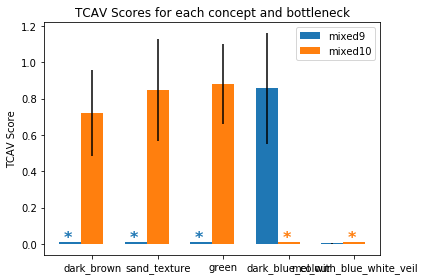

In [21]:
utils_plot.plot_results(results, random_concepts=random_concepts)

# Discussion

### Images as concepts
Advantages
* Domain experts think in terms of examples

Disadvantages
* Requires lots of images -> lots of time. Tools do exist to help https://github.com/hardikvasa/google-images-download
* Very hard to choose some examples of some concepts i.e. asymmetry

### Negative Images

How do you choose good random images??
Random image should be...
* Negative to *any* concept

No recommendations of how to choose random images by the author!
* I got many varied images, hopefully most of them will be negative to most concepts
* What else?  

Furthermore, how many random image sets are required? 

Validating / invalidating choice of random images?
* Can check the random concepts stddev


### Validating CAVs

How do you validate / invalidate CAVs? Especially difficult for high level features e.g. CEO, corgi, zebra, salmon, 

Paper does this in two ways.
* Sort images by CAVs
* Deep dreaming
    * Code is hidden behind IP...

Sorting images by maximum activation?

Validation still requires qualitative analysis!

How can I tell if I have bad positive images or negative images? 
* Look closely at output from individual experiments 

Let's look at our CAVs, what have they learned? Colour? Texture?


### More limitations

* Quite slow. can speed it up by doing less random concept calculations. But things can be done in parallel

### Some more hints
* Try using a concept that you think should have no effect on the class as a sanity check
* Only other parameter is alpha, "a regularizer penalty parameter for linear classifier to get CAVs"

### Further work
* investigation into different methods of scoring (somewhat done in regression concept vectors)


# The end~

## Extra resoruces
Regression concept vectors 
* "Instead of seeking a discriminator between two concepts (or one concept and random inputs), weseek the direction of greatest increase of the measures for a single continuous concept"
* Can be better suited to some domains
* link -  https://arxiv.org/pdf/1904.04520.pdf

Some talks / interviews by Been Kim
* https://www.quantamagazine.org/been-kim-is-building-a-translator-for-artificial-intelligence-20190110/#comments
* https://www.youtube.com/watch?v=Ff-Dx79QEEY
* https://www.youtube.com/watch?v=-y0oghbEHMM

images sources
* https://beenkim.github.io/slides/DLSS2018Vector_Been.pdf
* https://arxiv.org/pdf/1711.11279.pdf
* https://github.com/tensorflow/models/tree/master/research/inception
* https://beenkim.github.io/slides/TCAV_ICML_pdf.pdf